In [1]:
from sqlalchemy import *
import numpy as np
import pylab as plt
import pandas as pd
from peakdetect import peakdetect
from scipy.ndimage.interpolation import shift
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from scipy.optimize import newton
import peakutils
import random
%matplotlib inline

In [2]:
engine = create_engine('sqlite+pysqlite:///../data/SQL/85_8.db')

In [3]:
import time
start_time = time.time()
ADCdf = pd.io.sql.read_sql("SELECT * FROM ADC", engine)
#Hitdf = pd.io.sql.read_sql("SELECT * FROM Hit", engine)
#PSAdf = pd.io.sql.read_sql("SELECT * FROM PSA", engine)
#ProtoMapdf = pd.io.sql.read_sql("SELECT * FROM ProtoMap", engine)
#RawADCdf = pd.io.sql.read_sql("SELECT * FROM RawADC", engine)
end_time = time.time()
print end_time-start_time

203.67839098


In [4]:
def Process(Event):
    mesh = Event.iloc[:,3:][Event.iloc[:,3:]>20].sum(axis=0)
    return mesh
start_time = time.time()
mesh_df = ADCdf.groupby('EventID').apply(Process)
end_time = time.time()
print end_time-start_time

8.02539801598


In [5]:
def convolve(event):
    mesh_convol = np.convolve(event.values,([1]*10)[::-1],'same')
    return pd.Series(mesh_convol,index=['t'+str(i) for i in range(512)])
convol_df=mesh_df.apply(convolve,axis=1)
convol_df.reset_index(inplace=True)

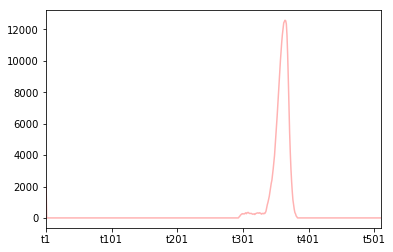

In [25]:
for idx,r in mesh_df.iterrows():
    plt.cla()
    r.iloc[1:].plot(legend=None,c=(1,0,0,0.3))
    plt.savefig(str(idx)+".png")

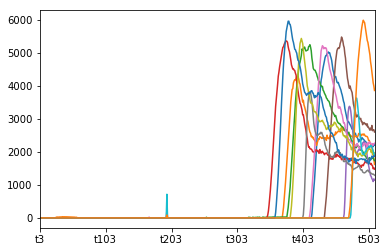

In [6]:
mesh_df[(mesh_df.iloc[:,-50:].sum(axis=1)>20000)&(mesh_df.iloc[:,3:350].sum(axis=1)<1000)].iloc[:,3:].T.plot(legend=None)


In [7]:
mesh_df[(mesh_df.iloc[:,-50:].sum(axis=1)>20000)&(mesh_df.iloc[:,3:350].sum(axis=1)<1000)].shape[0]

12

In [9]:
import plotly
plotly.offline.init_notebook_mode()
import plotly.plotly as py
from plotly.offline import iplot,plot
import plotly.graph_objs as go


In [10]:
tr1 = go.Scatter(y=convol_df.iloc[0,1:]/(convol_df.iloc[0,1:].max().astype(float)))
tr2 = go.Scatter(y=mesh_df.iloc[0,1:]/(mesh_df.iloc[0,1:].max().astype(float)))
tr3 = go.Scatter(x=[200], y=[0.5],mode='markers', marker=dict(size='16', color='rgba(152, 0, 0, .8)',))
tr4 = go.Scatter(x=[380], y=[0.1],mode='markers', marker=dict(size='16', color='rgba(152, 0, 0, .8)',))

iplot({"data": [tr1,tr2,tr3, tr4]})

#print Scatter(y=convol_df.iloc[0,1:])

In [559]:
obs = pd.read_csv('72_8.csv',header=None)
obs= obs.apply(pd.to_numeric)


In [81]:
obs.iloc[:2].values

array([[0, True],
       [1, True]], dtype=object)

In [6]:
fd_df = convol_df

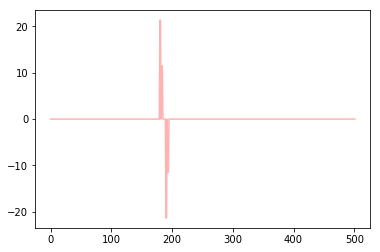

In [12]:
plt.plot(np.gradient(fd_df.iloc[:,1:].values,axis=1)[4,10:],c=(1,0,0,0.3));
#fd_df.head()
#np.gradient(fd_df.iloc[:,1:].values,axis=1).shape

In [7]:
def Process(r):
    grad = np.gradient(r.values[1:])
    xs = 10
    ys = -50
    grad_con = grad#np.convolve(grad,([1]*20)[::-1],'same')
    ratio = float(max(grad[xs:]))/max(grad_con)
    grad_con=grad_con*ratio
    idx_gradcon = peakutils.indexes(abs(grad_con[xs:ys]), thres=0.2, min_dist=5)
    
    if len(idx_gradcon)<1:
        return
    
    idx_1 = [x for x,y in zip(idx_gradcon+xs,grad_con[idx_gradcon+xs]) if y > 0]
    idx_2 = [x for x,y in zip(idx_gradcon+xs,grad_con[idx_gradcon+xs]) if y < 0]

    if not idx_1 or not idx_2:
        return
    return idx_2[-1], idx_1[0]#sorted(zip(idx_gradcon,grad_con[idx_gradcon]),key=lambda x:x[1])[-1][0]


start_time = time.time()
mask = (fd_df.iloc[:,1:].sum(axis=1)>300000)&(convol_df.iloc[:,1:].max(axis=1)<100000)

range_df = convol_df[mask].apply(Process, axis=1)
end_time = time.time()
print end_time-start_time

5.8236348629


In [14]:
print range_df.ix[253]

(217, 199)


153 141


array([141, 153, 184, 197, 388, 508])

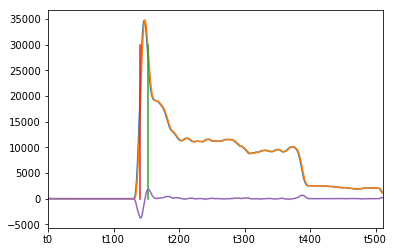

In [557]:
idx = 621
convol_df.ix[idx].iloc[2:].plot()
l,r, = Process(convol_df.ix[idx])
convol_df.ix[idx].iloc[1:].plot()
plt.plot([l,l],[0,30000])
plt.plot([r,r],[0,30000])
#plt.figure()
print l,r
plt.plot(-np.gradient(convol_df.ix[idx].iloc[1:]))
peakutils.indexes(abs(np.gradient(convol_df.ix[idx].iloc[1:])), thres=0.05, min_dist=10)

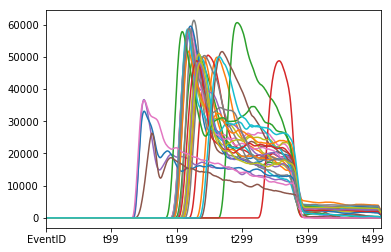

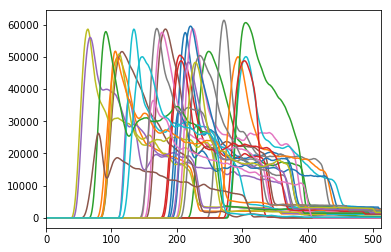

In [579]:
def GenerateData(r_df,d_df):

    r = r_df.sample(1)
    try:
        s = random.randint(50-r.values[0][1],450-r.values[0][0])
    except:
        print "bb",r.values[0]
        s = random.randint(50-r.values[0][1],400-r.values[0][1])
    #print r.index[0],s,r.values[0]

    tmp = d_df.ix[r.index[0]]
    tmp = tmp.copy(deep=True)
    tmp.iloc[:10] = 0

    if s:
        v = (int(s/abs(s)))
    else:
        v = 0
    
    tmp1 =  tmp.shift(s).replace(np.nan,tmp.iloc[v])
    tmp.plot()
    return tmp1

data = [] 

sub = range_df.ix[fd_df.index]
sub = sub[~sub.isnull()]
for _ in range(30):
    d = GenerateData(sub,fd_df)
    data.append(d.values)
data_df = pd.DataFrame(data)
data_df.T.plot(legend=None)

#print range_df[~range_df.isnull()3

In [17]:
fd_df.head()

,EventID,t0,t1,t2,t3,t4,t5,t6,t7,t8,...,t502,t503,t504,t505,t506,t507,t508,t509,t510,t511
0,0,13118.999920,15575.999905,17939.999905,20224.999905,22435.999910,24507.099886,24564.199850,23352.299849,22221.399849,...,264.1,260.1,258.1,254.1,402.900002,397.900002,376.400002,353.900002,328.400002,306.900002
1,1,4801.699982,5811.799978,6746.299974,7624.799971,8456.299967,9239.999964,9710.199961,9379.599962,9061.999964,...,0.0,0.0,0.0,21.6,86.500002,110.100002,110.100002,110.100002,110.100002,110.100002
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [18]:
range_df.index

Int64Index([   0,    1,    2,    5,    8,    9,   10,   11,   12,   13,
            ...
            1908, 1910, 1912, 1913, 1920, 1921, 1922, 1923, 1926, 1927],
           dtype='int64', length=1267)

383.0
1008.0
1095.0
1329.0
1568.0
1768.0


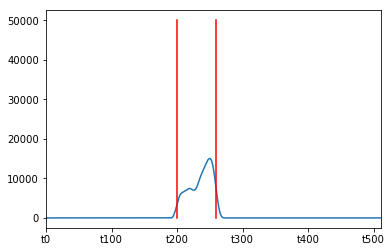

In [8]:
for ix,r in fd_df.iloc[range_df.index].iterrows():
    plt.cla()
    try:
        r.iloc[1:].plot()
        plt.plot([range_df.ix[r['EventID']][0]]*2,[0,50000],c='r')
        plt.plot([range_df.ix[r['EventID']][1]]*2,[0,50000],c='r')
        plt.savefig('{:04d}'.format(int(r['EventID']))+".png")
    except:
        print r['EventID']
    #plt.scatter(range_df.ix[r['EventID']],[500,500],marker='*',c='r')
    #print range_df.ix[r['EventID']]

In [452]:
fd_df.shape

(1591, 513)

In [426]:
fd_df

,EventID,t0,t1,t2,t3,t4,t5,t6,t7,t8,...,t502,t503,t504,t505,t506,t507,t508,t509,t510,t511
0,0,45.600000,45.600000,45.600000,45.600000,45.600000,45.600000,0.000000,0.0,0.0,...,2676.999996,2654.199997,2620.399998,2593.599998,2569.799999,2561.799999,2277.000000,2027.000000,1785.000000,1528.000000
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,1170.999969,1188.999969,1188.999969,1193.999969,1198.999969,1203.999969,1080.799973,959.599976,844.399979,718.199982
2,2,45.400000,45.400000,45.400000,45.400000,45.400000,45.400000,0.000000,0.0,0.0,...,1853.000000,1848.000000,1839.000000,1849.000000,1855.000000,1839.000000,1653.000000,1469.000000,1281.000000,1090.000000
3,3,56.100000,56.100000,56.100000,56.100000,56.100000,56.100000,0.000000,0.0,0.0,...,1780.999977,1783.999977,1776.999977,1773.999977,1771.999977,1764.999977,1592.599979,1412.199982,1238.799984,1056.399986
4,4,74.600000,74.600000,74.600000,74.600000,74.600000,74.600000,0.000000,0.0,0.0,...,2560.400013,2524.800013,2492.200012,2464.600012,2466.600012,2453.600012,2172.700012,1925.400013,1689.100010,1451.800007
5,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,6,21.500000,21.500000,21.500000,21.500000,21.500000,21.500000,0.000000,0.0,0.0,...,1157.999985,1160.999985,1158.999985,1151.999985,1151.999985,1152.999985,1038.899986,924.799988,807.699989,694.599991
7,7,75.600000,75.600000,75.600000,75.600000,75.600000,75.600000,0.000000,0.0,0.0,...,1753.999977,1759.999981,1745.999981,1753.999981,1761.999981,1787.999985,1618.399986,1441.799988,1260.199993,1087.599995
8,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,3227.999989,3202.999987,3168.999985,3131.999983,3105.999981,3069.999979,2754.699980,2438.399982,2119.099983,1794.799984
9,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


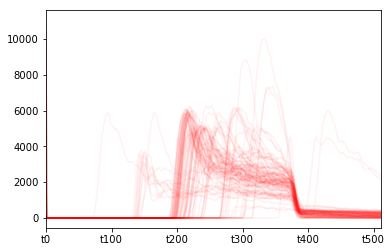

In [281]:
mesh_df.iloc[range_df[~range_df.isnull()].index].iloc[:100].T.plot(legend=None,c=(1,0,0,0.05))

In [527]:
#range_df.to_csv('range.csv')

In [589]:
range_df = pd.read_csv('range.csv',header=None)
range_df.columns=['index','range']
range_df = range_df['range'].str.extract('\((.*),(.*)\)',expand=False)
range_df.columns = ['left','right']
range_df = range_df.astype(np.float)

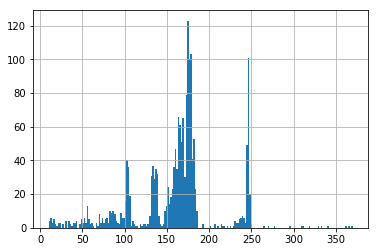

In [591]:
(range_df['left']-range_df['right']).hist(bins=200)

In [587]:
range_df.ix[0]

right    380.0
left     203.0
Name: 0, dtype: float64